# Sem-Supervised Graph Machine Learning Approach

In [1]:
import os 
import warnings
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F 

In [3]:
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [4]:
import torch_geometric.nn as gnn
from torch_cluster import knn_graph
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import add_self_loops
from torch_geometric.transforms import SamplePoints, NormalizeFeatures

In [5]:
warnings.filterwarnings("ignore")
device = "cpu" if torch.cuda.is_available() else "cpu"

### **The approach and the motivation behind applying Graph ML**


**Approach**

Graph Machine Learning is popular this days. We can translate this problem into a graph machine learning problem, by translating the tabular dataset into a graph dataset. The question comes **How**. We can treat each row (datapoint) as a node. Now we also have to connect those node with some edges in order to make a graph. So we construct those edges by using KNN graph algorithm. So based on some hyper-param `k` we are gonna make the k number of nearest neighbours as the edges for some target node i. And once done, our  tabular dataset gets translated into one single giant graph. Though we are sampling the number of nodes with class 0 in order to get the model overfitted and getting biased for class 0 and hence model will loose its generalizibilty. 

So our approach will be:
1. Create the graph dataset
2. Create a simple graph machine learning model.
3. Performing supervised approach like node classification technique to classify nodes on class 1 or 0
4. Semi supervised approach to cluster and visualize the node embedding (PCA/T-SNE) of the node embeddings

**Motivation**

Graph Machine Learning can model a problem on the grounds of supervised ML problem (node classification) here, Unsupervised or a semi supervised problem. Where we can perform the clustering of those node embedding. Another main motivation is, sometimes the data could also have some non-euclidean properties and through `message passing`, similar nodes must gather together so that we can see the clusters that can be seperable. So to see whether the data has some non-euclidean properties or not and whether it can be modelled that way, we are using Graph ML.

#### **Utility functions**

In [6]:
def scatter_3d_plot(x, y):
    """
    x : pd.DataFrame
    y : list
    """
    ax = plt.figure(figsize=(16,10)).gca(projection='3d')
    cols = x.columns
    ax.scatter(
        xs = x[cols[0]], 
        ys = x[cols[1]], 
        zs = x[cols[2]], 
        c  = y, 
        cmap='tab10')
    ax.set_xlabel('pca component one')
    ax.set_ylabel('pca component two')
    ax.set_zlabel('pca component three')
    
    plt.legend([f'class {i}' for i in np.unique(y)], loc="lower right")
    plt.show()

In [7]:
def visualize(h, color, n_components):
    z = TSNE(n_components=n_components, verbose = 1, perplexity=30, n_iter=600).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")

#### **Reading and pre-processing the data and sampling the classes**

In [76]:
data = pd.read_csv('new_physics_signal.csv')
data = data.dropna()
shuffled = data.sample(frac=1, random_state=4)
data_zero = shuffled.loc[shuffled['Class'] == 0].sample(n=800, random_state = 123)
data_one = shuffled.loc[shuffled['Class'] == 1]

data_sampled_concated = pd.concat([data_zero, data_one]).sample(frac=1, random_state=123)
data_sampled_concated = data_sampled_concated.reset_index(drop=True)
data = data_sampled_concated
columns = data.columns

In [9]:
data.shape

(1292, 15)

#### **Creating Graph Dataset using PyTorch Geometric**

A graph `G` consist of Node Feature matrix `(X)`, Topological information in the form of Edge Indinces `(A)`. X is nothing but the simple tabular features and we get the edge indices using KNN graph
algorithm

In [10]:
X_arr = np.array(data.iloc[:, :-1])
y_arr = np.array(data.iloc[:, -1:])

X = torch.tensor(X_arr, dtype=torch.float32)
y = torch.tensor(y_arr, dtype=torch.long).reshape(X.shape[0],)

In [11]:
train_mask = torch.zeros(data.shape[0], dtype=torch.bool)
test_mask = torch.zeros(data.shape[0], dtype=torch.bool)

In [12]:
train_idx_stop = X.shape[0] - int(0.1 * X.shape[0]) - 1

In [13]:
train_mask[pd.RangeIndex(start=0, stop=train_idx_stop, step=1)] = True
test_mask[pd.RangeIndex(start=train_idx_stop + 1, stop=X.shape[0], step=1)] = True

In [14]:
edge_index = knn_graph(X, k=1)
edge_index = add_self_loops(edge_index)[0]

In [15]:
GraphData = Data(x=X, edge_index = edge_index, y=y, train_mask = train_mask, test_mask = test_mask)
#GraphDataNorm = NormalizeFeatures()(GraphData)

#### **Graph ML model**

We create two models:

    1. GCN (Graph Convolutional Network)
    2. GAT (Graph Attention Network)

We try both but GAT performs slighly better than GCN.

In [58]:
class GCN_Model(torch.nn.Module):
    def __init__(self, in_features, out_features, num_classes):
        super(GCN_Model, self).__init__()
        self.conv1 = gnn.GATConv(in_features, out_features, heads=2, concat=True)
        self.conv2 = gnn.GATConv(2 * out_features, num_classes)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [59]:
class GAT_Model(torch.nn.Module):
    def __init__(self, in_features, out_features, num_classes):
        super(GAT_Model, self).__init__()
        self.conv1 = gnn.GATConv(in_features, out_features, heads=4, concat=True)
        self.conv2 = gnn.GATConv(4 * out_features, out_features // 2, heads = 2, concat = False)
        self.classifier = nn.Linear(out_features // 2, num_classes)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = self.classifier(x)
        return F.log_softmax(x, dim=1)

In [60]:
model = GAT_Model(14, 8, 2).to(device)
GraphData = GraphData.to(device)

In [61]:
model

GAT_Model(
  (conv1): GATConv(14, 8, heads=4)
  (conv2): GATConv(32, 4, heads=2)
  (classifier): Linear(in_features=4, out_features=2, bias=True)
)

#### **Training of the model**

In [62]:
criterion = F.nll_loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [63]:
def train(model):
    model.train()
    optimizer.zero_grad()
    y = GraphData.y[GraphData.train_mask]
    output = model(GraphData.x, GraphData.edge_index)[GraphData.train_mask]
    loss = criterion(output, y)
    loss.backward()
    optimizer.step()
    return loss.item(), model

In [64]:
def test(model, viz = False):
    with torch.no_grad():
        model.eval()
        x = GraphData.x
        y = GraphData.y
        edge_index = GraphData.edge_index
        train_mask = GraphData.train_mask
        test_mask = GraphData.test_mask
        
        logits = model(x, edge_index)
        train_predictions = logits[train_mask].max(1)[1]
        test_predictions = logits[test_mask].max(1)[1]
        train_acc = train_predictions.eq(y[train_mask]).sum().item() / train_mask.sum().item()
        test_acc = test_predictions.eq(y[test_mask]).sum().item() / test_mask.sum().item()
        if viz:
            visualize(logits, color=y.to('cpu'))
        return train_acc, test_acc

In [65]:
epochs = 10
for epoch in tqdm(range(1, epochs), total = epochs-1):
    loss, model = train(model)
    train_acc, test_acc = test(model, viz = False) 
    print(f"Epoch: {epoch} | Loss: {loss:.4f} Train ACC: {train_acc:.4f} Test ACC: {test_acc:.4f}")

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch: 1 | Loss: 33.0172 Train ACC: 0.6196 Test ACC: 0.6202
Epoch: 2 | Loss: 19.4761 Train ACC: 0.6196 Test ACC: 0.6202
Epoch: 3 | Loss: 11.4573 Train ACC: 0.6196 Test ACC: 0.6202
Epoch: 4 | Loss: 8.3742 Train ACC: 0.6196 Test ACC: 0.6202
Epoch: 5 | Loss: 8.7228 Train ACC: 0.6196 Test ACC: 0.6202
Epoch: 6 | Loss: 4.7840 Train ACC: 0.6196 Test ACC: 0.6202
Epoch: 7 | Loss: 2.8703 Train ACC: 0.6196 Test ACC: 0.6202
Epoch: 8 | Loss: 1.5293 Train ACC: 0.6196 Test ACC: 0.6202
Epoch: 9 | Loss: 1.5801 Train ACC: 0.6196 Test ACC: 0.6202


### **Embedding Visualization**

We visualize the embedding by passing the nodes to the trained model's last two layers.
We visualize through linear technique (PCA) and non linear technique (T-SNE) methods as follows

In [66]:
z1 = model.conv1(GraphData.x, GraphData.edge_index)
z2 = model.conv2(z1, GraphData.edge_index)

#### **Applying PCA on z1 and z2**

In [67]:
from sklearn.decomposition import PCA

In [68]:
def get_pca_for_scaled_data(x, y, n_components = 5, components_to_viz = 2):
    
    data = x.detach().numpy()
    y = y.detach().numpy()
    
    pca = PCA(n_components=n_components)
    pca_results = pca.fit_transform(data)
    
    pca_columns = [f'pca_comp{i+1}' for i in range(n_components)]
    pca_df = pd.DataFrame(columns = pca_columns)
    
    for i in range(n_components):
        pca_df[f"pca_comp{i+1}"] = pca_results[:, i]
        
    top_k = sorted(zip(pca_columns, pca.explained_variance_ratio_), reverse=True)[:components_to_viz]
    top_k_cols = [comp[0] for comp in top_k]
    print(f"The top {components_to_viz} components : {top_k_cols} with max variance of {top_k}")
          
    top_k_components = pca_df.loc[:, top_k_cols]
    
    if components_to_viz == 2:
        scatter_plot_representations(top_k_components.values, y)
    else:
        scatter_3d_plot(top_k_components, y)

The top 3 components : ['pca_comp5', 'pca_comp4', 'pca_comp3'] with max variance of [('pca_comp5', 3.31995e-05), ('pca_comp4', 7.1950555e-05), ('pca_comp3', 0.00043041984)]


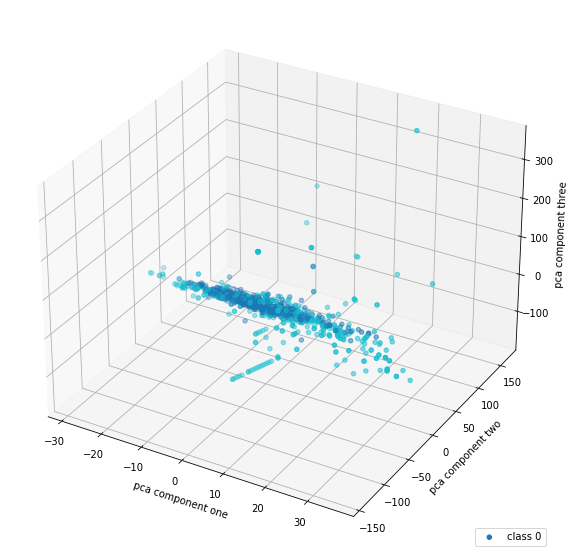

In [69]:
get_pca_for_scaled_data(z1, GraphData.y, n_components=5, components_to_viz=3)

The top 3 components : ['pca_comp3', 'pca_comp2', 'pca_comp1'] with max variance of [('pca_comp3', 4.664565e-05), ('pca_comp2', 0.002868026), ('pca_comp1', 0.9970772)]


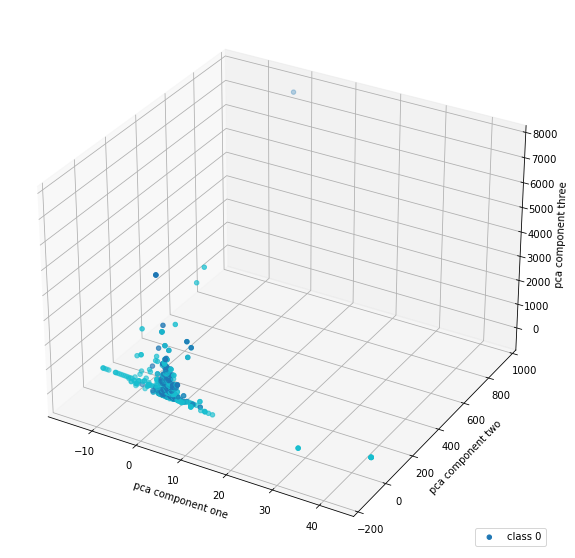

In [70]:
get_pca_for_scaled_data(z2, GraphData.y, n_components=3, components_to_viz=3)

#### **Applying T-SNE on z1 and z2**

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1292 samples in 0.001s...
[t-SNE] Computed neighbors for 1292 samples in 0.078s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1292
[t-SNE] Computed conditional probabilities for sample 1292 / 1292
[t-SNE] Mean sigma: 11.405714
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.370346
[t-SNE] KL divergence after 600 iterations: 0.344230


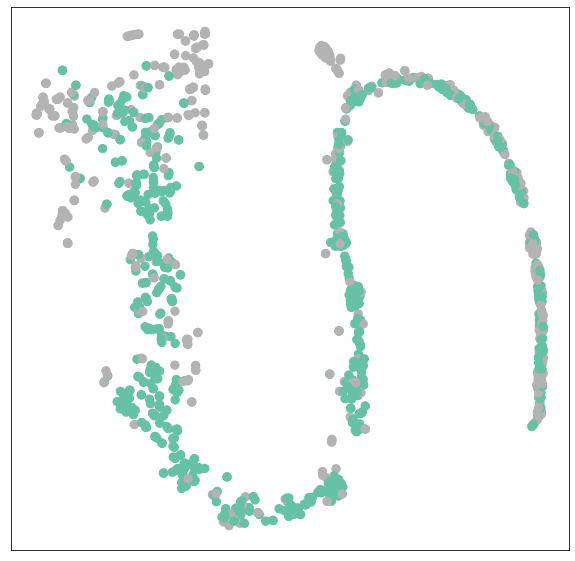

In [71]:
visualize(z1, y, n_components=2)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1292 samples in 0.003s...
[t-SNE] Computed neighbors for 1292 samples in 0.054s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1292
[t-SNE] Computed conditional probabilities for sample 1292 / 1292
[t-SNE] Mean sigma: 1.971320
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.349823
[t-SNE] KL divergence after 600 iterations: 0.293139


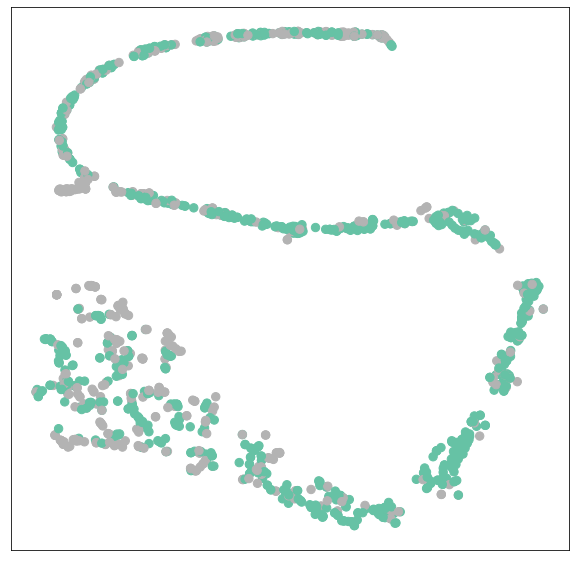

In [72]:
visualize(z2, y, n_components=2)

As we can see that the Graph ML approach does not create a significant difference here. What we can see from the embedding is that, the data belonging to class 1 is some how mixed with datapoints 
belonging to class 0. Regardless of using any type of approaches, we can see the overlapping between the embeddings. 

### Although, the results do not appear so good but applying Graph Machine Learning on such problems is an exciting and emerging new field.